## Example of running DeepRL



This notebook demonstrates how to use the `DeepRL` library to discover the governing partial differential equation (PDE) from data. We will use data generated from the Burgers' equation, initialize and train the model, and then visualize and analyze the results using the `deeprl_viz` toolkit.

In [1]:
import os
import sys
import numpy as np

current_dir = os.getcwd()
kd_main_dir = os.path.abspath(os.path.join(current_dir, ".."))
sys.path.append(kd_main_dir)
# Since the juppter's kernel might be running in a different directory
os.chdir(kd_main_dir) 

import scipy
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import warnings
warnings.filterwarnings("ignore", category=FutureWarning, module='numpy.*')
warnings.filterwarnings("ignore", category=UserWarning, module='tensorflow.*')
from kd.model import DeepRL
from kd.viz.discover_eq2latex import discover_program_to_latex 
from kd.viz.equation_renderer import render_latex_to_image
from kd.viz.deeprl_viz import *


## 1. Load and prepare data

We begin by loading the dataset for the Burgers' equation from a `.mat` file. The data consists of the solution $u(x, t)$ on a spatiotemporal grid. The `prepare_data` function handles loading, reshaping the data into coordinate pairs `(x, t)` and corresponding solution values `u`, and defining the domain bounds.

For this demonstration, the `DeepRL` model will use the full, regular grid data provided by the `import_inner_data` method for the 'Burgers' dataset.

In [2]:
model = DeepRL(
    n_samples_per_batch = 500, # Number of generated traversals by agent per batch
    binary_operators = ['add',"mul", "diff","diff2"],
    unary_operators = ['n2'],
)

np.random.seed(42)

model.import_inner_data(dataset='Burgers', data_type='regular')

-- BUILDING PRIOR START -------------
LengthConstraint: Sequences have minimum length 3.
                  Sequences have maximum length 64.
RepeatConstraint: [add] cannot occur more than 5 times.
TrigConstraint: [diff, diff2] cannot be a descendant of [diff, diff2].
SoftLengthPrior: No description available.
DiffConstraint_left: [x1] cannot be the left child of [diff, diff2].
DiffConstraint_right: [n2, add, mul, diff, diff2, u1] cannot be the right child of [diff, diff2].
DiffConstraint_des: [add] cannot be a descendant of [diff, diff2].
-- BUILDING PRIOR END ---------------



# 2. Train the model

In [3]:
step_output = model.train(n_epochs=51)

print(f"Current best expression is {step_output['expression']} and its reward is {step_output['r']}")

Progress:   0%|                                                              | 0/51 [00:00<?, ?it/s]/Users/hao/Code/proj/kd/env/lib/python3.9/site-packages/numba/np/ufunc/parallel.py:371: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  warnings.warn(problem)
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
Progress:   2%|█                                                     | 1/51 [00:01<01:32,  1.85s/it]

Training epoch 2/51, current best R: 0.9520, cost time: 1.85

	** New best
	Reward: 0.951975704788587
	MSE:5.914983969248237e-06
	Traversal: add,diff2,u1,x1,diff,n2,u1,x1
	Expression:
0.0984 * diff2(u1,x1) + -0.5002 * diff(n2(u1),x1)


Progress:  18%|█████████▌                                            | 9/51 [00:04<00:13,  3.19it/s]

Training epoch 10/51, current best R: 0.9520, cost time: 0.29


Progress:  37%|███████████████████▋                                 | 19/51 [00:07<00:09,  3.38it/s]

Training epoch 20/51, current best R: 0.9520, cost time: 0.30


Progress:  57%|██████████████████████████████▏                      | 29/51 [00:10<00:06,  3.23it/s]

Training epoch 30/51, current best R: 0.9520, cost time: 0.26


Progress:  76%|████████████████████████████████████████▌            | 39/51 [00:14<00:05,  2.26it/s]

Training epoch 40/51, current best R: 0.9520, cost time: 0.35


Progress:  96%|██████████████████████████████████████████████████▉  | 49/51 [00:18<00:00,  3.02it/s]

Training epoch 50/51, current best R: 0.9520, cost time: 0.29


Progress: 100%|█████████████████████████████████████████████████████| 51/51 [00:19<00:00,  2.67it/s]

-- Searching End ------------------
[SEARCH DEBUG INFO]: 
self.best_p.str_expression: 0.0984 * diff2(u1,x1) + -0.5002 * diff(n2(u1),x1)
self.best_p.traversal: add,diff2,u1,x1,diff,n2,u1,x1
program: add,diff2,u1,x1,diff,n2,u1,x1
type of first_term_node: <class 'kd.model.discover.stridge.Node'>
first_term_node: diff2(u1,x1)
repr(first_term_node): diff2(u1,x1)
Current best expression is 0.0984 * diff2(u1,x1) + -0.5002 * diff(n2(u1),x1) and its reward is 0.951975704788587


# 3. Visualization

### 3.1 Discovered Equation and Expression Tree

The best program discovered by the model can be visualized both as a rendered LaTeX equation for clarity and as a symbolic expression tree. The tree shows the hierarchical structure of the equation, with operators as parent nodes and their arguments as children. This helps in understanding the composition of the discovered PDE.

[discover_eq2latex INFO] Node 'diff2(u1,x1)'.to_sympy_string() -> 'Derivative(u1, x1, x1)'
[discover_eq2latex INFO] 解析后的SymPy表达式: Derivative(u1, (x1, 2))
[discover_eq2latex INFO] Node 'diff(n2(u1),x1)'.to_sympy_string() -> 'Derivative(Pow(u1, 2), x1)'
[discover_eq2latex INFO] 解析后的SymPy表达式: Derivative(u1**2, x1)


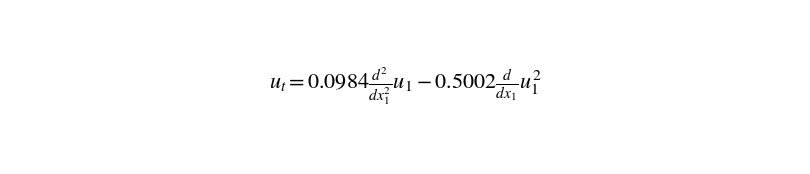

In [4]:
render_latex_to_image(discover_program_to_latex(step_output['program']))

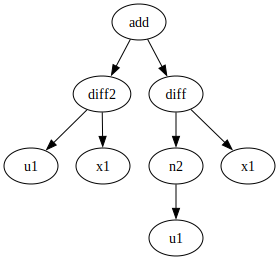

In [5]:
plot_expression_tree(model)

### 3.2 Training Diagnostics

These plots help diagnose the training process itself:

* **Density Plot:** This plot shows the distribution of rewards for all programs sampled at different stages of training (e.g., epochs 10, 30, 50). It helps visualize how the population of candidate solutions converges towards the high-reward region.
* **Evolution Plot:** This plot shows the evolution of rewards for the programs sampled in each training epoch. We can see how the agent improves over time, consistently finding programs with higher rewards as training progresses.


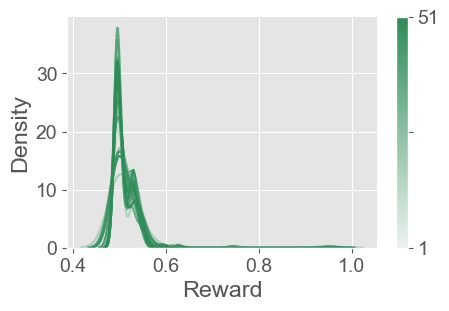

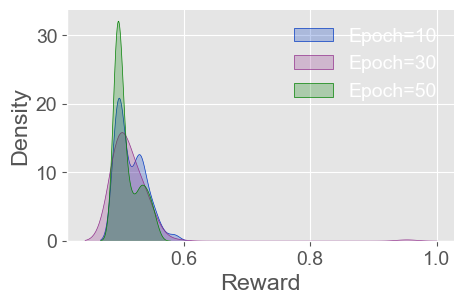

In [6]:
plot_density(model)
plot_density(model, epoches = [10,30,50])

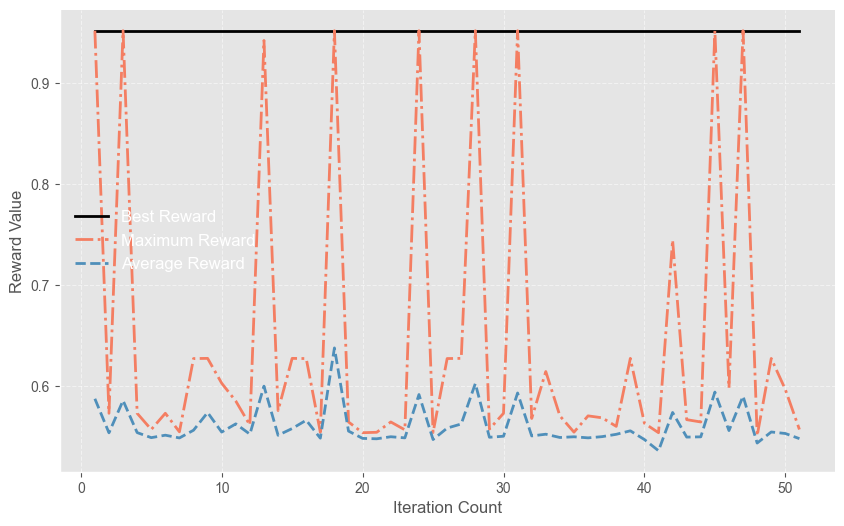

In [7]:
plot_evolution(model)

### 3.3 Residual Analysis

Residual analysis is a critical step to diagnose model fit. The **physical residual** is defined as $Residual = u_t - RHS$, where $u_t$ is the true time derivative and $RHS$ is the right-hand side of our discovered equation.

* **Spatiotemporal Distribution (Left):** This scatter plot shows *where* the errors occur across the space-time domain. Ideally, the points should be randomly colored around zero (white). Any clustering of colors (e.g., a region of all red) would indicate a systematic failure of the equation in that specific region.
* **Residual Distribution (Right):** This histogram shows the overall distribution of errors. An ideal model has residuals centered tightly around zero with a bell-like (normal) shape, which indicates that the model has no systematic bias.

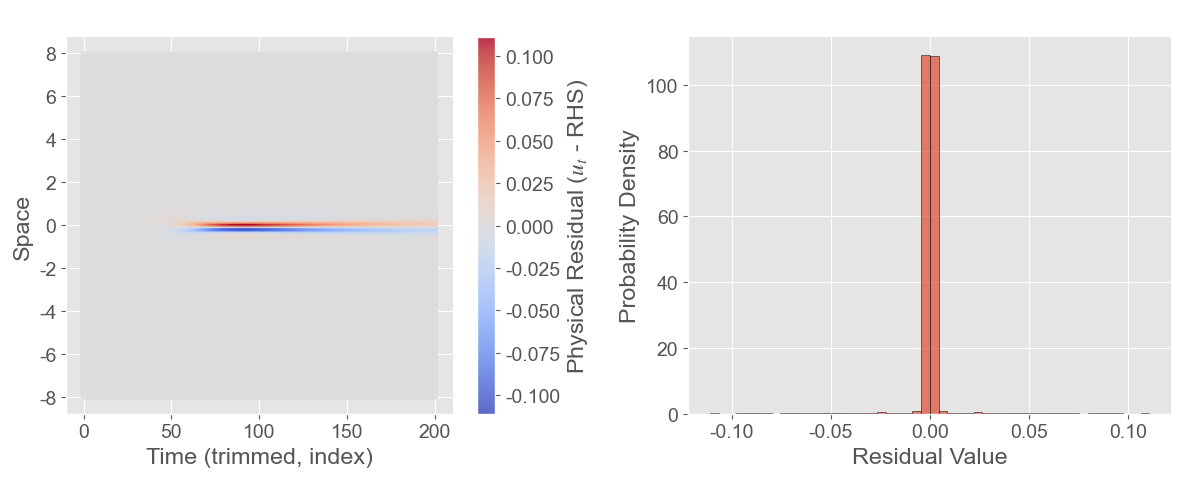

残差数组的形状: (51456,)
坐标数组的形状: (51456, 2)


In [8]:
plot_pde_residual_analysis(model, step_output['program'])
# 另一种使用方式
residuals, coords = plot_pde_residual_analysis(model, step_output['program'], show_plot=False)
print("残差数组的形状:", residuals.shape)
print("坐标数组的形状:", coords.shape)

### 3.4 Field Comparison

This visualization provides a side-by-side comparison of the true field ($u_t$) and the field generated by the RHS of our discovered equation. By using a shared color scale, we can intuitively see where the model's predictions match the ground truth and where they differ. For many applications, this is a more direct and intuitive way to assess model performance than the residual plot.

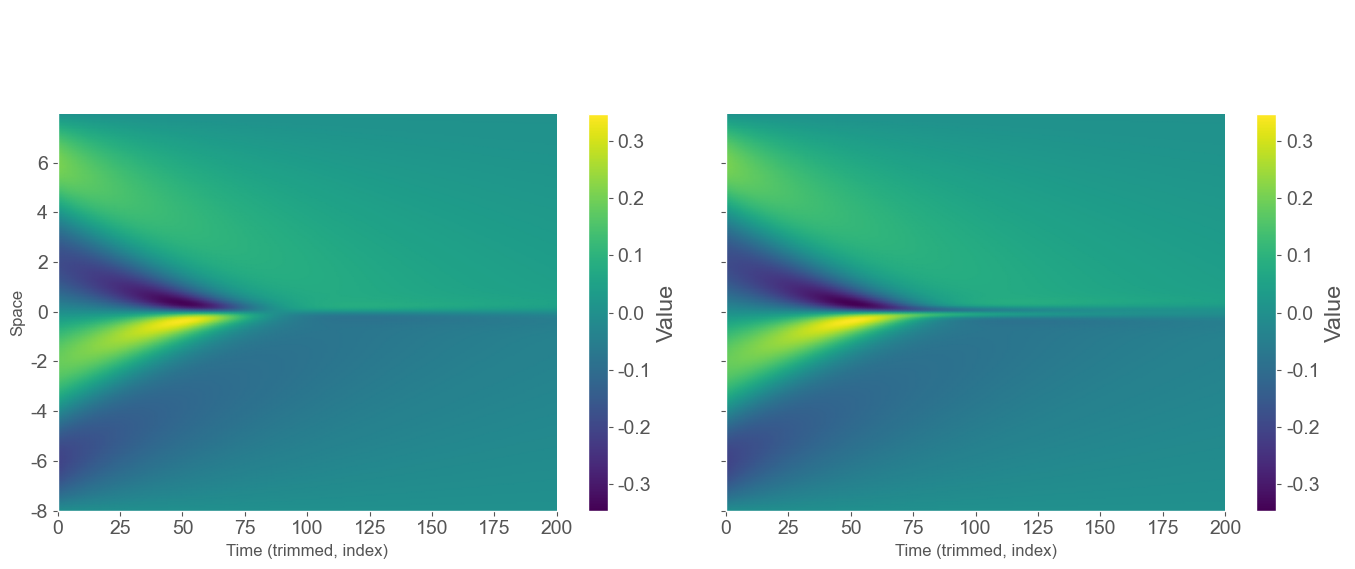

In [9]:
plot_field_comparison(model, step_output['program'])

### 3.5 Actual vs. Predicted

The 45-degree plot is a standard and powerful tool for evaluating regression models. Here, we plot the true values ($u_t$) on the x-axis against the predicted values (RHS) on the y-axis.

* **Overall Performance:** A perfect model would have all points lying exactly on the dashed `y=x` line. Our plot shows that for most points, the prediction is very accurate, as indicated by the tight clustering of points around the line. This confirms that the discovered equation captures the dominant dynamics of the system.
* **Systematic Error:** The most interesting feature is the loop-like structure in the center. This is not random noise but a **systematic error**. It suggests that the discovered equation, while very good, may be missing a term or a physical effect needed to fully capture the system's dynamics in certain regimes. This kind of structured error provides valuable insight for further model improvement.

Generating 'Actual vs. Predicted' plot...


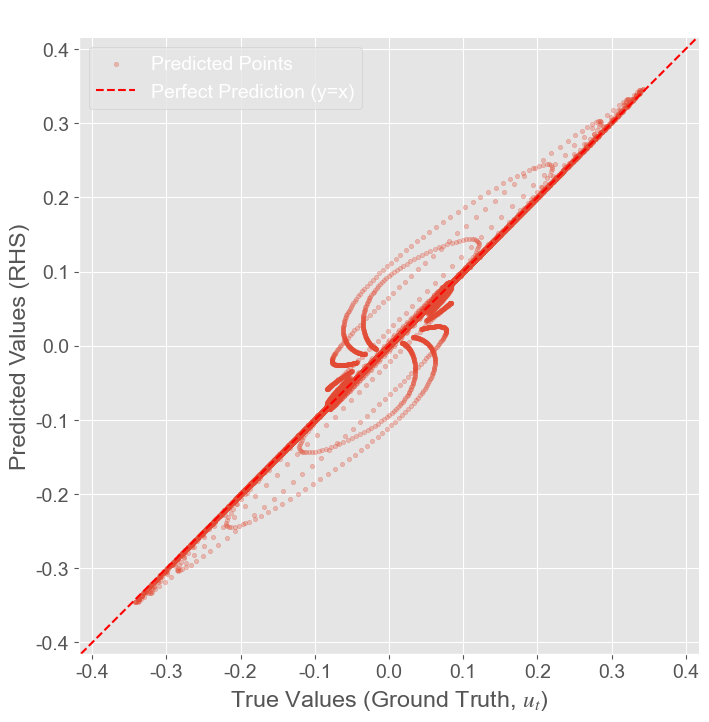

In [10]:
plot_actual_vs_predicted(model, step_output['program'])